# Edge Detection
Edges are caused by a variety of factors
* surface normal discontinuity
* depth discontinuity
* surface color discontinuity
* illumination discontinuity

Edge := rapid change in the image intensity function $f(x, y)$

## Finite difference
discrete differenciation:
$$
\frac{\partial f}{\partial x} [x, y] \approx F[x + 1, y] - F[x, y]
$$

This operation can be implemented as a linear filter:
$$
\frac{\partial f}{\partial x}: \begin{bmatrix} 0 & 0 & 0 \\ 0 & -1 & 1 \\ 0 & 0 & 0 \end{bmatrix}
$$
(Actually, this filter shifts the image by a half pixel)

## Image Gradient
The gradient of an image $f$ is
$$
\nabla f = \left[ \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right]
$$
its magnitude and direction is
$$
\mathrm{magnitude:} \quad \left\| \nabla f \right\| = \sqrt{\left(\frac{\partial f}{\partial x}\right)^2 + \left(\frac{\partial f}{\partial y}\right)^2} \\
\mathrm{direction:} \quad \theta = \mathrm{atan2} \left(\frac{\partial f}{\partial y}, \frac{\partial f}{\partial x}\right)
$$

In [1]:
import numpy as np
from PIL import Image

In [2]:
def finite_difference(image, axis):
    assert axis == 0 or axis == 1
    # difference along y-axis of an image is equivalent to
    # difference along x-axis of the transposed image
    if axis == 1:
        image = np.transpose(image, [1, 0, 2])
    
    h, w, _ = image.shape
    
    result = np.zeros_like(image)
    for i in range(h - 1):
        for j in range(w - 1):
            result[i, j, :] = image[i + 1, j, :] - image[i, j, :]
    if axis == 1:
        result = np.transpose(result, [1, 0, 2])
    return result

In [3]:
# prepare a sample image
img = Image.open("./img/640px-Common_zebra_1.jpg") # https://commons.wikimedia.org/wiki/File:Common_zebra_1.jpg
img = np.asarray(img).astype(np.float64) / 255.
# diffs
img_dx = finite_difference(img, 1)
img_dy = finite_difference(img, 0)
# magnitude
img_mg = np.sqrt(np.square(img_dx) + np.square(img_dy))

# visualization
img_dx = (img_dx - np.min(img_dx)) / (np.max(img_dx) - np.min(img_dx))
img_dy = (img_dy - np.min(img_dy)) / (np.max(img_dy) - np.min(img_dy))
img_mg = img_mg / np.max(img_mg)

Text(0.5, 1.0, 'magnitude')

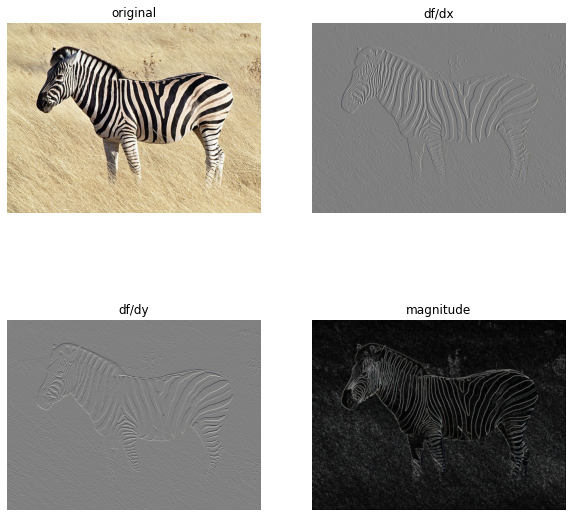

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("original")
plt.subplot(2, 2, 2)
plt.imshow(img_dx)
plt.axis("off")
plt.title("df/dx")
plt.subplot(2, 2, 3)
plt.imshow(img_dy)
plt.axis("off")
plt.title("df/dy")
plt.subplot(2, 2, 4)
plt.imshow(img_mg)
plt.axis("off")
plt.title("magnitude")

This method is simple but has a problem: noise

Text(0.5, 1.0, 'f(x)/dx')

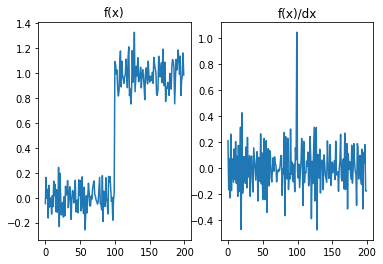

In [5]:
f = np.array([0.]*100 + [1.]*100)
f = f + np.random.normal(0., 0.1, 200)

# compute finite difference of f
df = np.empty((200, ))
for i in range(199):
    df[i] = f[i + 1] - f[i]
df[199] = df[198]
    
# plot f and df
ax = np.arange(200)
plt.subplot(1, 2, 1)
plt.plot(ax, f)
plt.title("f(x)")
plt.subplot(1, 2, 2)
plt.plot(ax, df)
plt.title("f(x)/dx")

The edge is not apparent in $\frac{df}{dx}$.

To deal with this noise effect, smooth the image first

Text(0.5, 1.0, 'd/dx g*f(x)')

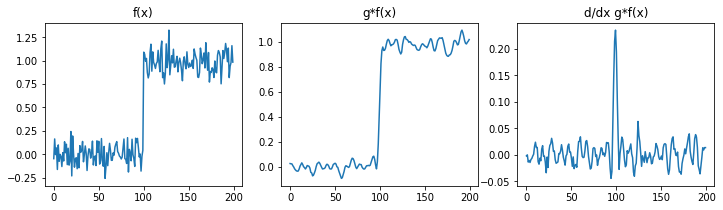

In [6]:
# prepare gaussian kernel
kernel = np.exp(-0.5 * np.square(np.arange(-3, 4) / 2.)) / np.sqrt(2 * np.pi * 2. * 2.)
kernel = kernel / np.sum(kernel)
# convolution
f_extend = np.concatenate((np.zeros((3, )), f, np.ones((3, ))))
f_smooth = np.zeros_like(f)
for i in range(200):
    f_smooth[i] = np.sum(f_extend[i:i+7] * kernel)
# finite difference
df_smooth = np.empty(200)
for i in range(199):
    df_smooth[i] = f_smooth[i + 1] - f_smooth[i]
df_smooth[199] = df_smooth[198]

# plot results
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.plot(ax, f)
plt.title("f(x)")
plt.subplot(1, 3, 2)
plt.plot(ax, f_smooth)
plt.title("g*f(x)")
plt.subplot(1, 3, 3)
plt.plot(ax, df_smooth)
plt.title("d/dx g*f(x)")

The edge now stands out in $\frac{d}{dx} g*f(x) $ ($g$ is Gaussian kernel).

## Sobel Filter
Because of the associative property of convolution, the following equation holds:
$$
\frac{d}{dx} (g * f) = \left( \frac{dg}{dx} \right) * f
$$

Sobel Filters are common approximation of derivative of Gaussian $\frac{dg}{dx}$
$$
\begin{aligned}
s_x &= \frac{1}{8} \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix} \\
s_y &= \frac{1}{8} \begin{bmatrix}  1 & 2 & 1 \\  0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}
\end{aligned}
$$

In [7]:
def pad(image, h_size, w_size):
    assert not (h_size == 0 and w_size == 0)
    extended_shape = list(image.shape)
    extended_shape[0] = extended_shape[0] + 2 * h_size
    extended_shape[1] = extended_shape[1] + 2 * w_size
    extended = np.empty(extended_shape)
    
    # center
    if h_size == 0:
        extended[:, w_size:-w_size, :] = image
    elif w_size == 0:
        extended[h_size:-h_size, :, :] = image
    else:
        extended[h_size:-h_size, w_size:-w_size, :] = image
    # edges and corners
    for i in range(h_size):
        extended[       i, :, :] = extended[       h_size, :, :]
        extended[-(i + 1), :, :] = extended[-(h_size + 1), :, :]
    for j in range(w_size):
        extended[:,        j, :] = extended[:,        w_size, :]
        extended[:, -(j + 1), :] = extended[:, -(w_size + 1), :]
    return extended        

In [8]:
def conv2d(image, kernel):
    # kernel size should be an odd number
    assert kernel.shape[0] % 2 == 1 and kernel.shape[1] % 2 == 1
    # here, assume a square kernel
    assert kernel.shape[0] == kernel.shape[1]
    
    m = kernel.shape[0]
    mdiv2 = m // 2
    h, w, c = image.shape
    
    # extend the image to apply a kernel to the edge of it
    extended = pad(image, mdiv2, mdiv2)
    
    # convolution
    # Most naive implementation: time complexity of O(HWCM^2)
    result = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            for k in range(-mdiv2, mdiv2 + 1):
                for l in range(-mdiv2, mdiv2 + 1):
                    for ch in range(c):
                        result[i, j, ch] += extended[i - k + mdiv2, j - l + mdiv2, ch] * kernel[mdiv2 + k, mdiv2 + l]
    return result        

In [9]:
sobel_x = np.array([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]]) / 8.
sobel_y = np.array([[1., 2., 1.], [0., 0., 0.], [-1., -2., -1.]]) / 8.

# apply sobel filters
img_dx = conv2d(img, sobel_x)
img_dy = conv2d(img, sobel_y)
img_mg = np.sqrt(np.square(img_dx) + np.square(img_dy))

# visualization
img_dx = (img_dx - np.min(img_dx)) / (np.max(img_dx) - np.min(img_dx))
img_dy = (img_dy - np.min(img_dy)) / (np.max(img_dy) - np.min(img_dy))
img_mg = img_mg / np.max(img_mg)

Text(0.5, 1.0, 'magnitude')

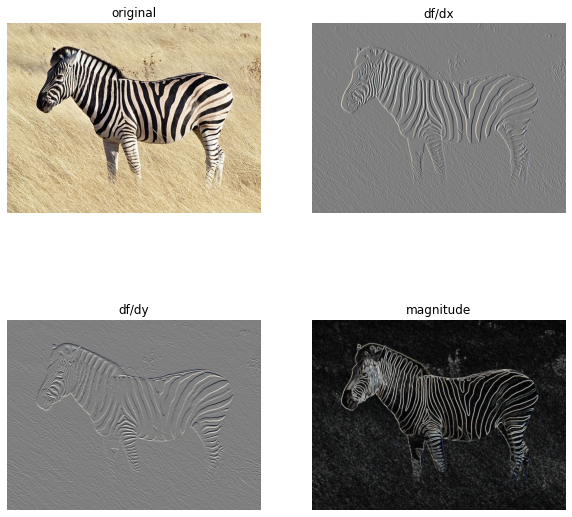

In [10]:
# show results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("original")
plt.subplot(2, 2, 2)
plt.imshow(img_dx)
plt.axis("off")
plt.title("df/dx")
plt.subplot(2, 2, 3)
plt.imshow(img_dy)
plt.axis("off")
plt.title("df/dy")
plt.subplot(2, 2, 4)
plt.imshow(img_mg)
plt.axis("off")
plt.title("magnitude")

## Non-Maximum Suppression
The curve extracted by Sobel filters is still too thick to find the edge even after thresholding.

Non-maximum suppression finds a thin curve which is most likely to be the edge.

In [11]:
def non_maximum_suppression(dx, dy):
    assert dx.shape == dy.shape and dx.ndim == 2
    
    magnitude = np.sqrt(np.square(dx) + np.square(dy))
    direction = np.arctan2(dy, dx)
    
    h, w = dx.shape
    result = np.zeros_like(dx)
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            if ((direction[i, j] > -0.75 * np.pi and direction[i, j] < -0.25 * np.pi) or
                (direction[i, j] > 0.25 * np.pi and direction[i, j] < 0.75 * np.pi)):
                # direction vector first intersects h-grids
                # tan(pi/2) theoretically needs to be handled
                w1 = 1. / np.tan(direction[i, j])
                w2 = -1. / np.tan(direction[i, j])
                # interpolation
                sign = 1 if w1 > 0. else -1
                p1 = magnitude[i + 1, j] * (1. - w1) + magnitude[i + 1, j + sign] * w1
                p2 = magnitude[i - 1, j] * (1. - w2) + magnitude[i - 1, j - sign] * w2
            else:
                # direction vector first intersects w-grids
                w1 = np.tan(direction[i, j])
                w2 = np.tan(direction[i, j])
                # interpolation
                sign = 1 if w1 > 0. else -1
                p1 = magnitude[i, j + 1] * (1. - w1) + magnitude[i, j + sign] * w1
                p2 = magnitude[i, j - 1] * (1. - w2) + magnitude[i, j - sign] * w2
            # local maximum
            if magnitude[i, j] > p1 and magnitude[i, j] > p2:
                result[i, j] = 1.
    return result

In [12]:
# merge channels
dx_norm = np.sqrt(np.sum(np.square(img_dx), axis=2))
dy_norm = np.sqrt(np.sum(np.square(img_dy), axis=2))

# threshold
mag = np.sqrt(np.square(dx_norm) + np.square(dy_norm))
mag_norm = mag / np.max(mag)

def threshold(dimg, refimg, val):
    return np.where(refimg < val, np.zeros_like(dimg), dimg)

high_threshold = 0.73
dx_norm_h = threshold(dx_norm, mag_norm, high_threshold)
dy_norm_h = threshold(dy_norm, mag_norm, high_threshold)
mag_threshold_h = threshold(mag_norm, mag_norm, high_threshold)

# low threshold
low_threshold = 0.6
dx_norm_l = threshold(dx_norm, mag_norm, low_threshold)
dy_norm_l = threshold(dy_norm, mag_norm, low_threshold)
mag_threshold_l = threshold(mag_norm, mag_norm, low_threshold)

# NMS
nms_h = non_maximum_suppression(dx_norm_h, dy_norm_h)
nms_l = non_maximum_suppression(dx_norm_l, dy_norm_l)

Text(0.5, 1.0, 'after nms')

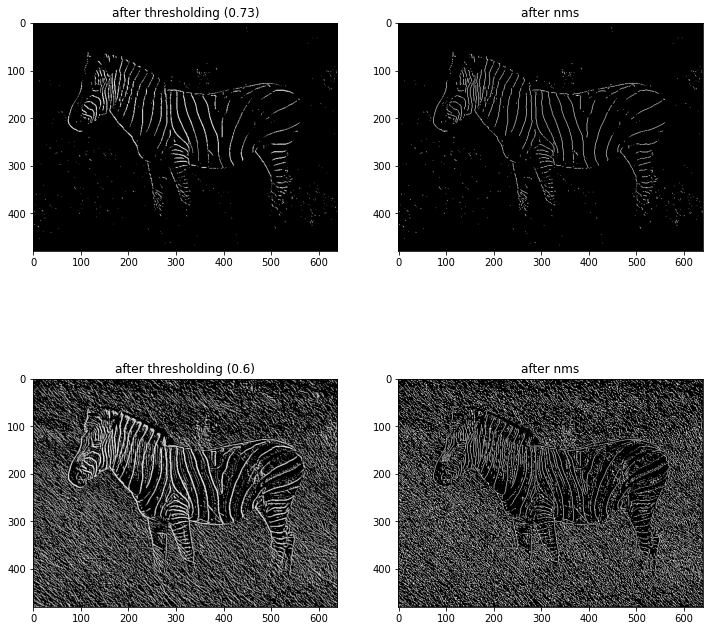

In [13]:
# show results
plt.figure(figsize=(12, 12))
# high threshold
plt.subplot(2, 2, 1)
plt.imshow(mag_threshold_h, cmap="Greys_r")
plt.title(f"after thresholding ({high_threshold})")
plt.subplot(2, 2, 2)
plt.imshow(nms_h, cmap="Greys_r")
plt.title("after nms")
# low threshold
plt.subplot(2, 2, 3)
plt.imshow(mag_threshold_l, cmap="Greys_r")
plt.title(f"after thresholding ({low_threshold})")
plt.subplot(2, 2, 4)
plt.imshow(nms_l, cmap="Greys_r")
plt.title("after nms")

## Canny Edge Detector
1. Apply the gradient of Gaussian filter (smoothing and differentiation)
1. Non-maximum suppression (edge thinning)
1. Hysteresis thresholding

Hysteresis thresholding starts with a point whose value is greater than the high threshold and extend the curve using the low threshold.

In [14]:
def hysteresis_threshold(high, low):
    assert high.shape == low.shape
    
    h, w = high.shape
    
    result = np.zeros_like(high)
    # blog analysis
    for i in range(h):
        for j in range(w):
            if high[i, j] > 0.5:
                # if a point is marked as an edge on the basis of the high threshold, 
                # mark it as the true edge
                result[i, j] = 1.
            elif low[i, j] > 0.5:
                # if a point is marked as an edge only on the basis of the low threshold, 
                # mark it as the true edge if it is connected with a strong edge
                if np.any(high[i - 1:i + 2, j - 1:j + 2] > 0.5):
                    result[i, j] = 1.
    return result

In [15]:
canny = hysteresis_threshold(nms_h, nms_l)

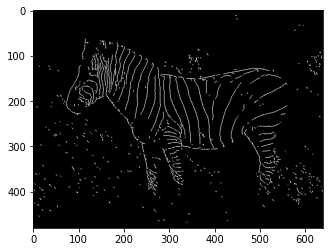

In [16]:
# show results
plt.imshow(canny, cmap="Greys_r")

## Laplacian Filter and LOG Filter
Laplacian as differentiation filter
$$
\nabla^2 f(x, y) = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}
$$
edge: intersection with zero

Better at localizing blurred edges than first-order derivative

LOG (Laplace of Gaussian) Filter: Laplacian operator combined with a smoothing filter

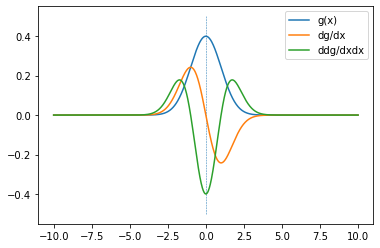

In [17]:
def g(x):
    return np.exp(-0.5 * x * x) / np.sqrt(2 * np.pi)
def dg(x):
    return -x * g(x)
def ddg(x):
    return -g(x) + x * x * g(x)

ax = np.linspace(-10., 10., 1000)
plt.plot(ax, g(ax), label="g(x)")
plt.plot(ax, dg(ax), label="dg/dx")
plt.plot(ax, ddg(ax), label="ddg/dxdx")
plt.legend()
plt.vlines(0, -0.5, 0.5, linestyle="dashed", linewidth=0.5)

In [18]:
def LOG_filter(image, kernel_size, stddev):
    mdiv2 = kernel_size // 2
    
    # create LOG kernel
    kernel = np.empty((kernel_size, kernel_size))
    mesh = np.arange(-mdiv2, mdiv2 + 1)
    i_mesh = np.repeat(mesh[:, np.newaxis], kernel_size, axis=1).astype(np.float64)
    j_mesh = np.repeat(mesh[np.newaxis, :], kernel_size, axis=0).astype(np.float64)
    
    r2 = np.square(i_mesh) + np.square(j_mesh)
    kernel = (r2 - 2. * stddev * stddev) * np.exp(-0.5 * r2 / (stddev * stddev))
    kernel = kernel / np.sum(kernel)
    
    # convolution of an image and the LOG kernel
    result = conv2d(image, kernel)
    return result

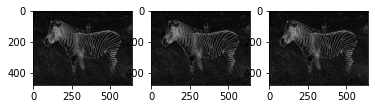

In [19]:
# apply LOG filter with some stddev values
for i, stddev in enumerate([1., 2., 3.]):
    log_img = LOG_filter(img, 7, 1.)
    
    # show results
    log_mag = np.sqrt(np.sum(np.square(log_img), axis=2))
    log_mag = log_mag / np.max(log_mag)
    plt.subplot(1, 3, i + 1)
    plt.imshow(log_mag, cmap="Greys_r")

# Corner
The corner is an extremely important feature:
* Image alignment
* 3D reconstruction
* Motion tracking
* Robot navigation
* others

## Harris Corner Detection
Consider Sum of the Squared Differences (SSD) btw a window $W$ and $W$ shifted by $(u, v)$:
$$
E(u, v) = \sum_{(x, y) \in W} \left[ I(x + u, y + v) - I(x, y) \right]^2.
$$
At a corner, this SSD significantly changes in all directions.
$E(u, v)$ is approximated as follows:

$$
\begin{aligned}
E(u, v) &\approx \sum_{(x, y) \in W} \left[ I(x, y) + I_x u + I_y v - I(x, y) \right]^2 \\
&= \sum_{(x, y) \in W} \left[ I_x u + I_y v \right]^2 \\
&= \left( \sum_{(x, y) \in W} I_x^2 \right) u^2 + 2 \left( \sum_{(x, y) \in W} I_x I_y \right) uv + \left( \sum_{(x, y) \in W} I_y^2 \right) v^2 \\
&= \begin{bmatrix} u & v \end{bmatrix} \begin{bmatrix} A & B \\ B & C \end{bmatrix} \begin{bmatrix} u \\ v \end{bmatrix}.
\end{aligned}
$$

Let $H$ be $\begin{bmatrix} A & B \\ B & C \end{bmatrix}$. When $E$ increases in all directions, eigenvalues of $H$ (let $\lambda_1, \lambda_2$ be them) are both large.

### Harris Operator
The Harris operator, $f$ defined as follows, is very similar to $\lambda_{\mathrm{min}}$ but less expensive:
$$
f = \frac{\lambda_1 \lambda_2}{\lambda_1 + \lambda_2} = \frac{\det(H)}{\mathrm{tr}(H)}.
$$

In [20]:
def harris_operator(image, window_size):
    # some constants
    h, w, _ = image.shape
    wdiv2 = window_size // 2
    
    # compute gradients of the image
    dx = conv2d(image, sobel_x)
    dy = conv2d(image, sobel_y)
    # padding
    dx = pad(dx, wdiv2, wdiv2)
    dy = pad(dy, wdiv2, wdiv2)
    # magnitude of gradients
    dx = np.sqrt(np.sum(np.square(dx), axis=2))
    dy = np.sqrt(np.sum(np.square(dy), axis=2))
    # f-values
    f = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            h_matrix = np.zeros((2, 2))
            for k in range(-wdiv2, wdiv2 + 1):
                for l in range(-wdiv2, wdiv2 + 1):
                    i_offset = i + k + wdiv2
                    j_offset = j + l + wdiv2
                    h_matrix = h_matrix + np.array([[dx[i_offset, j_offset] * dx[i_offset, j_offset], dx[i_offset, j_offset] * dy[i_offset, j_offset]], 
                                                    [dy[i_offset, j_offset] * dx[i_offset, j_offset], dy[i_offset, j_offset] * dy[i_offset, j_offset]]])
            if np.trace(h_matrix) == 0.:
                f[i, j] = 0.
            else:
                f[i, j] = np.linalg.det(h_matrix) / np.trace(h_matrix)
    return f

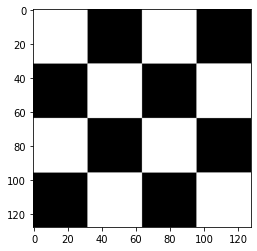

In [21]:
# prepare a checker board
w, h = 128, 128
checker = np.zeros((w, h, 1))
nw, nh = 4, 4
for i in range(nh):
    for j in range(nw):
        if (i + j) % 2 == 0:
            checker[i*h//nh:(i+1)*h//nh, j*w//nw:(j+1)*w//nw, 0] = 1.
plt.imshow(checker, cmap="Greys_r")

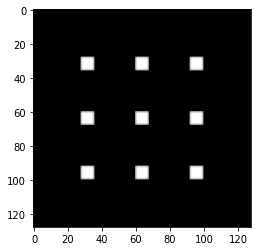

In [22]:
f_value = harris_operator(checker, 7)
plt.imshow(f_value / np.max(f_value), cmap="Greys_r")

Let's apply this Harris corner detection to a bit more complex image.

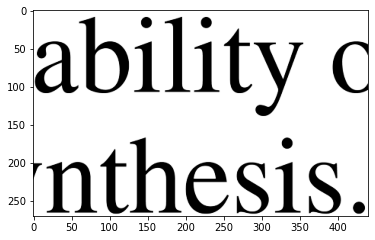

In [23]:
letters = Image.open("./img/letters.png")
letters = np.asarray(letters).astype(np.float64) / 255.
letters = np.mean(letters, axis=2, keepdims=True)
plt.imshow(letters, cmap="Greys_r")

In [24]:
f_values = harris_operator(letters, 5)

In [25]:
# find local maxima
def find_local_max(image, kernel_size, threshold):
    mdiv2 = kernel_size // 2
    h, w = image.shape
    # padding (add ch-axis for pad() function)
    extended = pad(image[:, :, np.newaxis], mdiv2, mdiv2)
    extended = np.reshape(extended, (h + kernel_size - 1, w + kernel_size - 1))
    max_filter = np.zeros_like(image)

    for i in range(h):
        for j in range(w):
            max_filter[i, j] = np.max(extended[i:i+kernel_size, j:j+kernel_size])
    # mask small values
    masked = np.where(max_filter == image, max_filter, np.zeros_like(max_filter))
    # thresholding
    result = np.where(masked > threshold, masked, np.zeros_like(masked))
    return result

normal_f = f_values / np.max(f_values)
corners = find_local_max(normal_f, 3, 0.3)

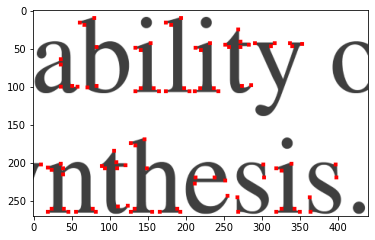

In [26]:
# put found corners on the original image
stack = np.repeat(letters, 3, axis=2)
red_img = np.array([[[1., 0., 0.]]])
red_img = np.repeat(red_img, letters.shape[0], axis=0)
red_img = np.repeat(red_img, letters.shape[1], axis=1)
# make points bigger
emphasized = np.zeros_like(corners)
for i in range(corners.shape[0]):
    for j in range(corners.shape[1]):
        if corners[i, j] > 0.2:
            emphasized[i - 2:i + 3, j - 2:j + 3] = corners[i, j]
stack = np.where(np.repeat(emphasized[:, :, np.newaxis], 3, axis=2) < 0.3, stack, red_img)

plt.imshow(stack)